In [1]:
import os
import h5py
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization,DepthwiseConv2D
from tensorflow.keras.layers import Activation,AveragePooling2D,Conv2D, RepeatVector, Permute, Multiply
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from tcn import TCN
from sklearn.metrics import confusion_matrix,classification_report


In [2]:
import numpy as np
import h5py
import glob # Used to find all file paths
import os

BASE_PATH = 'Final Project data/Cross'

TRAIN_DIR = os.path.join(BASE_PATH, 'train/')
TEST1_DIR = os.path.join(BASE_PATH, 'test1/')
TEST2_DIR = os.path.join(BASE_PATH, 'test2/')
TEST3_DIR = os.path.join(BASE_PATH, 'test3/')

# Each file has 248 sensor readings (rows) and 35624 time steps (columns)
N_CHANNELS = 248
N_TIMESTEPS = 35624

# The 4 states we want to classify
TASKS = ['rest', 'task_motor', 'task_story_math', 'task_working_memory']
# Map tasks to integer labels
task_to_label = {task: i for i, task in enumerate(TASKS)}

# Function to load data from a list of file paths
def load_data(file_paths):
    data = []
    labels = []
    for file_path in file_paths:
        # Extractin the label
        filename = file_path.split('/')[-1]

        #handling the different task naming conventions
        if 'rest' in filename:
            labels.append(task_to_label['rest'])
        elif 'motor' in filename:
            labels.append(task_to_label['task_motor'])
        elif 'story' in filename or 'math' in filename:
             labels.append(task_to_label['task_story_math'])
        elif 'working' in filename or 'memory' in filename:
            labels.append(task_to_label['task_working_memory'])
        else:
            # iff a file doesn't match
            print(f"Could not determine task for file: {filename}")
            continue

        with h5py.File(file_path, 'r') as f:
            # Instead of guessing the dataset name, we get the first key from the file
            # This is robust because we know there is only one dataset per file[cite: 10].
            dataset_name = list(f.keys())[0]
            matrix = f[dataset_name][()]
            data.append(matrix)

    #convert to numpy arrays
    return np.array(data), np.array(labels)

train_files = glob.glob(f"{TRAIN_DIR}/*.h5")
test1_files = glob.glob(f"{TEST1_DIR}/*.h5")
test2_files = glob.glob(f"{TEST2_DIR}/*.h5")
test3_files = glob.glob(f"{TEST3_DIR}/*.h5")
intra_file = glob.glob(f"{os.path.join('Final Project data/Intra', 'train/')}/*.h5")


X_train, y_train = load_data(train_files)
X_test1, y_test1 = load_data(test1_files)
X_test2, y_test2 = load_data(test2_files)
X_test3, y_test3 = load_data(test3_files)

X_train_intra, y_train_intra = load_data(intra_file)


# X_train = np.concatenate((X_train, X_train_intra), axis=0)
# y_train = np.concatenate((y_train, y_train_intra), axis=0)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test1: {X_test1.shape}")
print(f"Uniqe labels: {np.unique(y_train)}")
print(f"Number of training samples: {len(X_train)}")

Shape of X_train: (64, 248, 35624)
Shape of y_train: (64,)
Shape of X_test1: (16, 248, 35624)
Uniqe labels: [0 1 2 3]
Number of training samples: 64


In [3]:
from sklearn.preprocessing import StandardScaler ,Normalizer ,MinMaxScaler


# --- Downsampling ---
# The original sample rate is 2034Hz
#take every 10th sample
DOWNSAMPLE_FACTOR = 10
X_train_ds = X_train[:, :, ::DOWNSAMPLE_FACTOR]
X_test1_ds = X_test1[:, :, ::DOWNSAMPLE_FACTOR]
X_test2_ds = X_test2[:, :, ::DOWNSAMPLE_FACTOR]
X_test3_ds = X_test3[:, :, ::DOWNSAMPLE_FACTOR]

N_TIMESTEPS_DS = X_train_ds.shape[2]
print(f"Original number of time steps: {N_TIMESTEPS}")
print(f"Downsampled number of time steps: {N_TIMESTEPS_DS}")


# --- Time-wise Normalization ---
#normalize each channel's time-series independently.


def normalize_data(data):
    # Data shape is (n_samples, n_channels, n_timesteps)
    # We want to scale each of the (n_samples * n_channels) time series

    # Reshape to (n_samples * n_channels, n_timesteps) to apply StandardScaler
    n_samples, n_channels, n_timesteps = data.shape
    reshaped_data = data.reshape(n_samples * n_channels, n_timesteps)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(reshaped_data)

    # Reshape back to the original shape
    return scaled_data.reshape(n_samples, n_channels, n_timesteps)

print("\nNormalizing data...")
X_train_norm = normalize_data(X_train_ds)
X_test1_norm = normalize_data(X_test1_ds)
X_test2_norm = normalize_data(X_test2_ds)
X_test3_norm = normalize_data(X_test3_ds)

#DL models in Keras often expect the channel dimension last
#reshaping from (samples, channels, timesteps) to (samples, timesteps, channels)
X_train_final = np.transpose(X_train_norm, (0, 2, 1))
X_test1_final = np.transpose(X_test1_norm, (0, 2, 1))
X_test2_final = np.transpose(X_test2_norm, (0, 2, 1))
X_test3_final = np.transpose(X_test3_norm, (0, 2, 1))

print("Normalization complete.")
print(f"Final shape of training data for the model: {X_train_final.shape}")

Original number of time steps: 35624
Downsampled number of time steps: 3563

Normalizing data...
Normalization complete.
Final shape of training data for the model: (64, 3563, 248)


In [4]:
def add_noise(data, noise_factor=0.05):
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=data.shape)
    return data + noise

def scale_amplitude(data, scale_factor_range=(0.9, 1.1)):
    scaler = np.random.uniform(low=scale_factor_range[0], high=scale_factor_range[1])
    return data * scaler


X_train_augmented = []
y_train_augmented = []

for i in range(len(X_train_final)):
    original_sample = X_train_final[i]
    original_label = y_train[i]

    X_train_augmented.append(original_sample)
    y_train_augmented.append(original_label)

    augmented_sample = add_noise(original_sample)
    augmented_sample = scale_amplitude(augmented_sample)
    X_train_augmented.append(augmented_sample)
    y_train_augmented.append(original_label)


# Convert the lists back to numpy arrays
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)
print(f"Shape of augmented training data: {X_train_augmented.shape}")

print(X_train_augmented.min(), X_train_augmented.max())

Shape of augmented training data: (128, 3563, 248)
-32.417206147174326 7.267772900866241


# Optimizer

In [5]:
def window_data(X, y, window_size=200, step_size=100):
    """
    Create overlapping windows of shape (window_size, channels) from each trial.
    Input shape: (samples, timesteps, channels)
    Output shape: (num_windows, window_size, channels)
    """
    X_windows = []
    y_windows = []
    for i in range(int(X.shape[0])):  # iterate over samples
        sample = X[i]  # (timesteps, channels)
        label = y[i]
        for start in range(0, sample.shape[0] - window_size + 1, step_size):
            end = start + window_size
            X_windows.append(sample[start:end])
            y_windows.append(label)

    return np.array(X_windows), np.array(y_windows)

In [6]:
import optuna

def make_objective(build_model_fn):
    def objective(trial):
        # Suggest window and step sizes
        window_size = trial.suggest_int("window_size", 100, 400, step=50)
        step_size = trial.suggest_int("step_size", 50, 300, step=25)

        # Re-window the data
        X_train_win, y_train_win = window_data(X_train_augmented, y_train_augmented, window_size, step_size)
        X_test1_win, y_test1_win = window_data(X_test1_final, y_test1, window_size, step_size)
        X_test2_win, y_test2_win = window_data(X_test2_final, y_test2, window_size, step_size)
        X_test3_win, y_test3_win = window_data(X_test3_final, y_test3, window_size, step_size)

        NUM_CLASSES = len(np.unique(y_train_win))

        # Avoid invalid shapes
        if X_train_win.shape[1] != window_size:
            return 0.0

        input_shape = (window_size, X_train_win.shape[2])
        model = build_model_fn(input_shape, NUM_CLASSES)  # Flexible model passed here
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train for a few epochs (quick tuning)
        model.fit(X_train_win, y_train_win, batch_size=32, epochs=5, validation_split=0.2, verbose=0)

        # Evaluate
        _, acc1 = model.evaluate(X_test1_win, y_test1_win, verbose=0)
        _, acc2 = model.evaluate(X_test2_win, y_test2_win, verbose=0)
        _, acc3 = model.evaluate(X_test3_win, y_test3_win, verbose=0)
        avg_acc = (acc1 + acc2 + acc3) / 3

        return avg_acc
    return objective

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CNN 

In [15]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=64, kernel_size=10, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=4),
        Conv1D(filters=128, kernel_size=10, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=4),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model




study = optuna.create_study(direction='maximize')
study.optimize(make_objective(build_cnn_model), n_trials=20)

study.

print("Best parameters:", study.best_params)
print(f"Best accuracy: {study.best_value * 100:.2f}%")

print()
print()
print()
print()


# Re-window the data
X_train_win, y_train_win = window_data(X_train_augmented, y_train_augmented, study.best_params['window_size'], study.best_params['step_size'])
X_test1_win, y_test1_win = window_data(X_test1_final, y_test1, study.best_params['window_size'], study.best_params['step_size'])
X_test2_win, y_test2_win = window_data(X_test2_final, y_test2, study.best_params['window_size'], study.best_params['step_size'])
X_test3_win, y_test3_win = window_data(X_test3_final, y_test3, study.best_params['window_size'], study.best_params['step_size'])

NUM_CLASSES = len(np.unique(y_train_win))

INPUT_SHAPE = (study.best_params['window_size'], X_train_win.shape[2])

simple_cnn = build_cnn_model(INPUT_SHAPE, NUM_CLASSES)

simple_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

simple_cnn.summary()

# --- Training ---
simple_cnn.fit(
    X_train_win,
    y_train_win,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    verbose=2
)



# Evaluate on test sets
loss1_simple_cnn, acc1_simple_cnn = simple_cnn.evaluate(X_test1_win, y_test1_win, verbose=0)
print(f"simple_cnn Model Accuracy on Test Set 1: {acc1_simple_cnn * 100:.2f}%")
loss2_simple_cnn, acc2_simple_cnn = simple_cnn.evaluate(X_test2_win, y_test2_win, verbose=0)
print(f"simple_cnn Model Accuracy on Test Set 2: {acc2_simple_cnn * 100:.2f}%")
loss3_simple_cnn, acc3_simple_cnn = simple_cnn.evaluate(X_test3_win, y_test3_win, verbose=0)
print(f"simple_cnn Model Accuracy on Test Set 3: {acc3_simple_cnn * 100:.2f}%")

print(f"Average accuracy: {((acc1_simple_cnn + acc2_simple_cnn +acc3_simple_cnn)/3) * 100:.2f}%")


y_pred_probs = simple_cnn.predict(X_test1_win)

# 2. Convert to class labels (e.g., 0, 1, 2, 3)
y_pred = np.argmax(y_pred_probs, axis=1)
print("Evaluation")
print(confusion_matrix(y_test1_win, y_pred))
print(classification_report(y_test1_win, y_pred))
loss, acc = simple_cnn.evaluate(X_test1_win, y_test1_win, verbose=0)
print(f"Loss: {loss:.4f}, Accuracy: {acc:.4f}")



[I 2025-06-15 12:23:17,357] A new study created in memory with name: no-name-28e2fb29-a24d-40ab-8382-53d47bc7967e
[I 2025-06-15 12:23:29,355] Trial 0 finished with value: 0.6970238188902537 and parameters: {'window_size': 125, 'step_size': 100}. Best is trial 0 with value: 0.6970238188902537.
[I 2025-06-15 12:23:45,212] Trial 1 finished with value: 0.6209935943285624 and parameters: {'window_size': 350, 'step_size': 125}. Best is trial 0 with value: 0.6970238188902537.
[I 2025-06-15 12:23:57,406] Trial 2 finished with value: 0.6758578419685364 and parameters: {'window_size': 200, 'step_size': 100}. Best is trial 0 with value: 0.6970238188902537.
[I 2025-06-15 12:24:27,080] Trial 3 finished with value: 0.6540767351786295 and parameters: {'window_size': 100, 'step_size': 25}. Best is trial 0 with value: 0.6970238188902537.
[I 2025-06-15 12:24:37,743] Trial 4 finished with value: 0.6349637707074484 and parameters: {'window_size': 250, 'step_size': 150}. Best is trial 0 with value: 0.69702

Best parameters: {'window_size': 375, 'step_size': 150}
Best accuracy: 73.77%






Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_40 (Conv1D)              │ (None, 375, 64)        │       158,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 375, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_40 (MaxPooling1D) │ (None, 93, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 93, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 93, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_41 (MaxPooling1D) │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 2944)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │       376,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 619,076 (2.36 MB)

 Trainable params: 618,692 (2.36 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
71/71 - 3s - 38ms/step - accuracy: 0.9618 - loss: 0.1474 - val_accuracy: 0.8936 - val_loss: 0.4491
Epoch 2/20
71/71 - 2s - 30ms/step - accuracy: 0.9991 - loss: 0.0018 - val_accuracy: 0.9291 - val_loss: 0.1569
Epoch 3/20
71/71 - 2s - 30ms/step - accuracy: 0.9960 - loss: 0.0123 - val_accuracy: 0.9823 - val_loss: 0.0565
Epoch 4/20
71/71 - 2s - 30ms/step - accuracy: 0.9973 - loss: 0.0113 - val_accuracy: 1.0000 - val_loss: 4.2273e-10
Epoch 5/20
71/71 - 2s - 32ms/step - accuracy: 0.9929 - loss: 0.0593 - val_accuracy: 0.8121 - val_loss: 1.4831
Epoch 6/20
71/71 - 2s - 30ms/step - accuracy: 0.9933 - loss: 0.0616 - val_accuracy: 0.9805 - val_loss: 0.2269
Epoch 7/20
71/71 - 2s - 31ms/step - accuracy: 0.9893 - loss: 0.0988 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/20
71/71 - 2s - 32ms/step - accuracy: 0.9987 - loss: 0.0043 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 9/20
71/71 - 2s - 34ms/step - accuracy: 0.9991 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 0.000

In [25]:


# Evaluate on test sets
loss1_simple_cnn, acc1_simple_cnn = simple_cnn.evaluate(X_test1_win, y_test1_win, verbose=0)
print(f"simple_cnn Model Accuracy on Test Set 1: {acc1_simple_cnn * 100:.2f}%")
loss2_simple_cnn, acc2_simple_cnn = simple_cnn.evaluate(X_test2_win, y_test2_win, verbose=0)
print(f"simple_cnn Model Accuracy on Test Set 2: {acc2_simple_cnn * 100:.2f}%")
loss3_simple_cnn, acc3_simple_cnn = simple_cnn.evaluate(X_test3_win, y_test3_win, verbose=0)
print(f"simple_cnn Model Accuracy on Test Set 3: {acc3_simple_cnn * 100:.2f}%")

print(f"Average accuracy: {((acc1_simple_cnn + acc2_simple_cnn +acc3_simple_cnn)/3) * 100:.2f}%")



print("Evaluation for test 1")
y_pred_probs = simple_cnn.predict(X_test1_win)
y_pred = np.argmax(y_pred_probs, axis=1)
# print(confusion_matrix(y_test1_win, y_pred))
report1 = classification_report(y_test1_win, y_pred)
print(report1)

print("Evaluation for test 2")
y_pred_probs = simple_cnn.predict(X_test2_win)
y_pred = np.argmax(y_pred_probs, axis=1)
# print(confusion_matrix(y_test2_win, y_pred))
report1 =classification_report(y_test2_win, y_pred)
print(report1)

print("Evaluation for test 3")
y_pred_probs = simple_cnn.predict(X_test3_win)
y_pred = np.argmax(y_pred_probs, axis=1)
# print(confusion_matrix(y_test3_win, y_pred))
report1 =classification_report(y_test3_win, y_pred)
print(report1)


simple_cnn Model Accuracy on Test Set 1: 88.64%
simple_cnn Model Accuracy on Test Set 2: 43.18%
simple_cnn Model Accuracy on Test Set 3: 70.17%
Average accuracy: 67.33%
Evaluation for test 1
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       0.85      1.00      0.92        88
           2       0.79      1.00      0.88        88
           3       1.00      0.55      0.71        88

    accuracy                           0.89       352
   macro avg       0.91      0.89      0.88       352
weighted avg       0.91      0.89      0.88       352

Evaluation for test 2
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        88
           1       0.42      0.73      0.53        88
           2       0.00      0.00      0.00        88
           3       0.00      0.00      0.00        88



# LSTM

In [8]:
#Hybrid CNN-LSTM Model Architecture
from tensorflow.keras.layers import LSTM

def build_cnn_lstm_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),

        # Convolutional layers to extract features
        Conv1D(filters=64, kernel_size=10, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=4),

        Conv1D(filters=128, kernel_size=10, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=4),

        # LSTM layer to model temporal sequences of the extracted features
        LSTM(128, return_sequences=False), # return_sequences=False  it's the last recurrent layer

        # Dense layers for classification
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model




study = optuna.create_study(direction='maximize')
study.optimize(make_objective(build_cnn_lstm_model), n_trials=20)

print("Best parameters:", study.best_params)
print(f"Best accuracy: {study.best_value * 100:.2f}%")

print()
print()
print()
print()



# Re-window the data
X_train_win, y_train_win = window_data(X_train_augmented, y_train_augmented, study.best_params['window_size'], study.best_params['step_size'])
X_test1_win, y_test1_win = window_data(X_test1_final, y_test1, study.best_params['window_size'], study.best_params['step_size'])
X_test2_win, y_test2_win = window_data(X_test2_final, y_test2, study.best_params['window_size'], study.best_params['step_size'])
X_test3_win, y_test3_win = window_data(X_test3_final, y_test3, study.best_params['window_size'], study.best_params['step_size'])

NUM_CLASSES = len(np.unique(y_train_win))

INPUT_SHAPE = (study.best_params['window_size'], X_train_win.shape[2])

cnn_lstm_model = build_cnn_lstm_model(INPUT_SHAPE, NUM_CLASSES)

cnn_lstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_lstm_model.summary()

# --- Training ---
cnn_lstm_model.fit(
    X_train_win,
    y_train_win,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    verbose=2
)



# Evaluate on test sets
loss1_hybrid, acc1_hybrid = cnn_lstm_model.evaluate(X_test1_final, y_test1, verbose=0)
print(f"Hybrid Model Accuracy on Test Set 1: {acc1_hybrid * 100:.2f}%")
loss2_hybrid, acc2_hybrid = cnn_lstm_model.evaluate(X_test2_final, y_test2, verbose=0)
print(f"Hybrid Model Accuracy on Test Set 2: {acc2_hybrid * 100:.2f}%")
loss3_hybrid, acc3_hybrid = cnn_lstm_model.evaluate(X_test3_final, y_test3, verbose=0)
print(f"Hybrid Model Accuracy on Test Set 3: {acc3_hybrid * 100:.2f}%")

print(f"Average accuracy: {((acc1_hybrid + acc2_hybrid +acc3_hybrid)/3) * 100:.2f}%")


[I 2025-06-15 13:10:40,502] A new study created in memory with name: no-name-e39632b6-22cd-4514-ac98-7c9928a1f24b
[I 2025-06-15 13:11:05,820] Trial 0 finished with value: 0.6171296238899231 and parameters: {'window_size': 225, 'step_size': 75}. Best is trial 0 with value: 0.6171296238899231.
[I 2025-06-15 13:11:15,741] Trial 1 finished with value: 0.5464285711447397 and parameters: {'window_size': 100, 'step_size': 100}. Best is trial 0 with value: 0.6171296238899231.
[I 2025-06-15 13:11:36,134] Trial 2 finished with value: 0.7137681245803833 and parameters: {'window_size': 125, 'step_size': 50}. Best is trial 2 with value: 0.7137681245803833.
[I 2025-06-15 13:11:43,918] Trial 3 finished with value: 0.6547619104385376 and parameters: {'window_size': 100, 'step_size': 125}. Best is trial 2 with value: 0.7137681245803833.
[I 2025-06-15 13:12:07,265] Trial 4 finished with value: 0.6829427083333334 and parameters: {'window_size': 375, 'step_size': 100}. Best is trial 2 with value: 0.713768

Best parameters: {'window_size': 250, 'step_size': 75}
Best accuracy: 74.54%






Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_40 (Conv1D)              │ (None, 250, 64)        │       158,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 250, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_40 (MaxPooling1D) │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 62, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 62, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_41 (MaxPooling1D) │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,212 (1.49 MB)

 Trainable params: 389,828 (1.49 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
144/144 - 5s - 34ms/step - accuracy: 0.9796 - loss: 0.0736 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 2/20
144/144 - 4s - 27ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9905 - val_loss: 0.0203
Epoch 3/20
144/144 - 4s - 27ms/step - accuracy: 1.0000 - loss: 3.3385e-04 - val_accuracy: 0.9887 - val_loss: 0.0270
Epoch 4/20
144/144 - 4s - 27ms/step - accuracy: 0.9996 - loss: 0.0032 - val_accuracy: 0.9913 - val_loss: 0.0439
Epoch 5/20
144/144 - 4s - 27ms/step - accuracy: 0.9928 - loss: 0.0238 - val_accuracy: 1.0000 - val_loss: 1.2630e-04
Epoch 6/20
144/144 - 4s - 28ms/step - accuracy: 0.9967 - loss: 0.0139 - val_accuracy: 0.9931 - val_loss: 0.0341
Epoch 7/20
144/144 - 4s - 29ms/step - accuracy: 1.0000 - loss: 4.8691e-04 - val_accuracy: 0.9957 - val_loss: 0.0137
Epoch 8/20
144/144 - 4s - 27ms/step - accuracy: 1.0000 - loss: 3.1066e-04 - val_accuracy: 1.0000 - val_loss: 5.3194e-06
Epoch 9/20
144/144 - 4s - 28ms/step - accuracy: 1.0000 - loss: 1.1818e-04 - val_accu

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization,DepthwiseConv2D
from tensorflow.keras.layers import Activation,AveragePooling2D,Conv2D, RepeatVector, Permute, Multiply
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from tcn import TCN




def build_temporal_attention_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    x = Conv1D(64, 15, padding='same', activation='relu')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling1D(4)(x)
    x = Conv1D(128, 15, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(4)(x)

    # Attention-like mechanism
    attention = Dense(1, activation='tanh')(x)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(128)(attention)
    attention = Permute([2, 1])(attention)

    x = Multiply()([x, attention])
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    return model






study = optuna.create_study(direction='maximize')
study.optimize(make_objective(build_temporal_attention_model), n_trials=20)

print("Best parameters:", study.best_params)
print(f"Best accuracy: {study.best_value * 100:.2f}%")

print()
print()
print()
print()



# Re-window the data
X_train_win, y_train_win = window_data(X_train_augmented, y_train_augmented, study.best_params['window_size'], study.best_params['step_size'])
X_test1_win, y_test1_win = window_data(X_test1_final, y_test1, study.best_params['window_size'], study.best_params['step_size'])
X_test2_win, y_test2_win = window_data(X_test2_final, y_test2, study.best_params['window_size'], study.best_params['step_size'])
X_test3_win, y_test3_win = window_data(X_test3_final, y_test3, study.best_params['window_size'], study.best_params['step_size'])


# --- Model Setup ---
NUM_CLASSES = len(np.unique(y_train))

INPUT_SHAPE = (study.best_params['window_size'], X_train_win.shape[2])
temporal_attention_model = build_temporal_attention_model(INPUT_SHAPE, NUM_CLASSES)

temporal_attention_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

temporal_attention_model.summary()

# --- Training ---
temporal_attention_model.fit(
    X_train_win,
    y_train_win,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    verbose=2
)



# Evaluate on test sets
loss1_temporal_attention, acc1_temporal_attention = temporal_attention_model.evaluate(X_test1_win, y_test1_win, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 1: {acc1_temporal_attention * 100:.2f}%")
loss2_temporal_attention, acc2_temporal_attention = temporal_attention_model.evaluate(X_test2_win, y_test2_win, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 2: {acc2_temporal_attention * 100:.2f}%")
loss3_temporal_attention, acc3_temporal_attention = temporal_attention_model.evaluate(X_test3_win, y_test3_win, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 3: {acc3_temporal_attention * 100:.2f}%")

print(f"Average accuracy: {((acc1_temporal_attention + acc2_temporal_attention +acc3_temporal_attention)/3) * 100:.2f}%")




[I 2025-06-15 13:26:20,400] A new study created in memory with name: no-name-45762589-bb58-42ca-9fc3-a20a94a93160


[I 2025-06-15 13:26:35,665] Trial 0 finished with value: 0.672839492559433 and parameters: {'window_size': 200, 'step_size': 125}. Best is trial 0 with value: 0.672839492559433.
[I 2025-06-15 13:26:47,421] Trial 1 finished with value: 0.658482164144516 and parameters: {'window_size': 175, 'step_size': 125}. Best is trial 0 with value: 0.672839492559433.
[I 2025-06-15 13:27:09,743] Trial 2 finished with value: 0.6314102411270142 and parameters: {'window_size': 375, 'step_size': 125}. Best is trial 0 with value: 0.672839492559433.
[I 2025-06-15 13:27:24,545] Trial 3 finished with value: 0.686887244383494 and parameters: {'window_size': 200, 'step_size': 100}. Best is trial 3 with value: 0.686887244383494.
[I 2025-06-15 13:27:34,734] Trial 4 finished with value: 0.6785714328289032 and parameters: {'window_size': 150, 'step_size': 125}. Best is trial 3 with value: 0.686887244383494.
[I 2025-06-15 13:27:55,577] Trial 5 finished with value: 0.6712962985038757 and parameters: {'window_size': 

: 

In [ ]:
# Evaluate on test sets
loss1_temporal_attention, acc1_temporal_attention = temporal_attention_model.evaluate(X_test1_win, y_test1_win, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 1: {acc1_temporal_attention * 100:.2f}%")
loss2_temporal_attention, acc2_temporal_attention = temporal_attention_model.evaluate(X_test2_win, y_test2_win, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 2: {acc2_temporal_attention * 100:.2f}%")
loss3_temporal_attention, acc3_temporal_attention = temporal_attention_model.evaluate(X_test3_win, y_test3_win, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 3: {acc3_temporal_attention * 100:.2f}%")

print(f"Average accuracy: {((acc1_temporal_attention + acc2_temporal_attention +acc3_temporal_attention)/3) * 100:.2f}%")

temporal attention Model Accuracy on Test Set 1: 97.46%
temporal attention Model Accuracy on Test Set 2: 25.00%
temporal attention Model Accuracy on Test Set 3: 71.48%
Average accuracy: 64.65%


In [7]:
def build_tcn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        TCN(nb_filters=64, kernel_size=5, dilations=[1, 2, 4, 8, 16], return_sequences=False),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model




study = optuna.create_study(direction='maximize')
study.optimize(make_objective(build_tcn_model), n_trials=20)

print("Best parameters:", study.best_params)
print(f"Best accuracy: {study.best_value * 100:.2f}%")

print()
print()
print()
print()



# Re-window the data
X_train_win, y_train_win = window_data(X_train_augmented, y_train_augmented, study.best_params['window_size'], study.best_params['step_size'])
X_test1_win, y_test1_win = window_data(X_test1_final, y_test1, study.best_params['window_size'], study.best_params['step_size'])
X_test2_win, y_test2_win = window_data(X_test2_final, y_test2, study.best_params['window_size'], study.best_params['step_size'])
X_test3_win, y_test3_win = window_data(X_test3_final, y_test3, study.best_params['window_size'], study.best_params['step_size'])


# --- Model Setup ---
NUM_CLASSES = len(np.unique(y_train))

INPUT_SHAPE = (study.best_params['window_size'], X_train_win.shape[2])
build_tcn_model_model = build_tcn_model(INPUT_SHAPE, NUM_CLASSES)

build_tcn_model_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

build_tcn_model_model.summary()

# --- Training ---
build_tcn_model_model.fit(
    X_train_win,
    y_train_win,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    verbose=2
)



# Evaluate on test sets
loss1_build_tcn_model, acc1_build_tcn_model = build_tcn_model_model.evaluate(X_test1_win, y_test1_win, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 1: {acc1_build_tcn_model * 100:.2f}%")
loss2_build_tcn_model, acc2_build_tcn_model = build_tcn_model_model.evaluate(X_test2_win, y_test1_win, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 2: {acc2_build_tcn_model * 100:.2f}%")
loss3_build_tcn_model, acc3_build_tcn_model = build_tcn_model_model.evaluate(X_test3_win, y_test1_win, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 3: {acc3_build_tcn_model * 100:.2f}%")

print(f"Average accuracy: {((acc1_build_tcn_model + acc2_build_tcn_model +acc3_build_tcn_model)/3) * 100:.2f}%")


[I 2025-06-15 13:41:35,350] A new study created in memory with name: no-name-11bbb9f9-9a88-4eef-82a9-53c194993e3e
[I 2025-06-15 13:41:49,308] Trial 0 finished with value: 0.710937519868215 and parameters: {'window_size': 100, 'step_size': 150}. Best is trial 0 with value: 0.710937519868215.
[I 2025-06-15 13:42:11,632] Trial 1 finished with value: 0.7006579041481018 and parameters: {'window_size': 300, 'step_size': 175}. Best is trial 0 with value: 0.710937519868215.
[I 2025-06-15 13:42:40,795] Trial 2 finished with value: 0.6905637184778849 and parameters: {'window_size': 200, 'step_size': 100}. Best is trial 0 with value: 0.710937519868215.
[I 2025-06-15 13:43:28,757] Trial 3 finished with value: 0.6412760416666666 and parameters: {'window_size': 400, 'step_size': 100}. Best is trial 0 with value: 0.710937519868215.
[I 2025-06-15 13:43:38,859] Trial 4 finished with value: 0.6689814925193787 and parameters: {'window_size': 100, 'step_size': 200}. Best is trial 0 with value: 0.710937519

Best parameters: {'window_size': 100, 'step_size': 100}
Best accuracy: 77.44%






Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn_20 (TCN)                    │ (None, 64)             │       280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,516 (1.07 MB)

 Trainable params: 280,516 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
112/112 - 4s - 36ms/step - accuracy: 0.9280 - loss: 0.5100 - val_accuracy: 1.0000 - val_loss: 0.0062
Epoch 2/20
112/112 - 3s - 28ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 5.7232e-05
Epoch 3/20
112/112 - 3s - 26ms/step - accuracy: 1.0000 - loss: 5.8929e-04 - val_accuracy: 1.0000 - val_loss: 1.0823e-05
Epoch 4/20
112/112 - 3s - 26ms/step - accuracy: 1.0000 - loss: 1.7982e-04 - val_accuracy: 1.0000 - val_loss: 6.3349e-06
Epoch 5/20
112/112 - 3s - 26ms/step - accuracy: 0.9967 - loss: 0.0169 - val_accuracy: 1.0000 - val_loss: 0.0051
Epoch 6/20
112/112 - 3s - 28ms/step - accuracy: 0.9992 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 7.8054e-06
Epoch 7/20
112/112 - 3s - 27ms/step - accuracy: 1.0000 - loss: 1.1410e-05 - val_accuracy: 1.0000 - val_loss: 7.0750e-06
Epoch 8/20
112/112 - 3s - 28ms/step - accuracy: 0.9994 - loss: 0.0013 - val_accuracy: 0.9911 - val_loss: 0.0576
Epoch 9/20
112/112 - 3s - 27ms/step - accuracy: 1.0000 - loss: 4.8579e-0

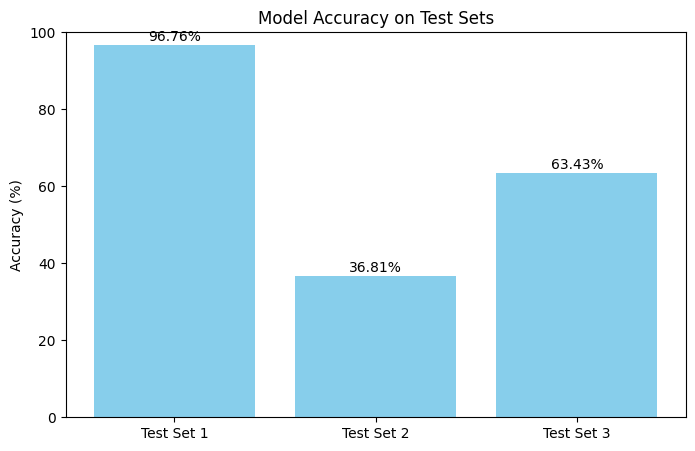

In [ ]:
accuracies = [acc1_build_tcn_model, acc2_build_tcn_model, acc3_build_tcn_model]
test_sets = ['Test Set 1', 'Test Set 2', 'Test Set 3']

# Plot accuracy bar chart
plt.figure(figsize=(8, 5))
plt.bar(test_sets, [a * 100 for a in accuracies], color='skyblue')
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy on Test Sets')
for i, acc in enumerate(accuracies):
    plt.text(i, acc * 100 + 1, f"{acc * 100:.2f}%", ha='center')
plt.show()